In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
from pathlib import Path
from collections import Counter

In [3]:
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix
from imblearn.metrics import classification_report_imbalanced

# Read the CSV and Perform Basic Data Cleaning

In [4]:
# https://help.lendingclub.com/hc/en-us/articles/215488038-What-do-the-different-Note-statuses-mean-

columns = [
    "loan_amnt", "int_rate", "installment", "home_ownership",
    "annual_inc", "verification_status", "issue_d", "loan_status",
    "pymnt_plan", "dti", "delinq_2yrs", "inq_last_6mths",
    "open_acc", "pub_rec", "revol_bal", "total_acc",
    "initial_list_status", "out_prncp", "out_prncp_inv", "total_pymnt",
    "total_pymnt_inv", "total_rec_prncp", "total_rec_int", "total_rec_late_fee",
    "recoveries", "collection_recovery_fee", "last_pymnt_amnt", "next_pymnt_d",
    "collections_12_mths_ex_med", "policy_code", "application_type", "acc_now_delinq",
    "tot_coll_amt", "tot_cur_bal", "open_acc_6m", "open_act_il",
    "open_il_12m", "open_il_24m", "mths_since_rcnt_il", "total_bal_il",
    "il_util", "open_rv_12m", "open_rv_24m", "max_bal_bc",
    "all_util", "total_rev_hi_lim", "inq_fi", "total_cu_tl",
    "inq_last_12m", "acc_open_past_24mths", "avg_cur_bal", "bc_open_to_buy",
    "bc_util", "chargeoff_within_12_mths", "delinq_amnt", "mo_sin_old_il_acct",
    "mo_sin_old_rev_tl_op", "mo_sin_rcnt_rev_tl_op", "mo_sin_rcnt_tl", "mort_acc",
    "mths_since_recent_bc", "mths_since_recent_inq", "num_accts_ever_120_pd", "num_actv_bc_tl",
    "num_actv_rev_tl", "num_bc_sats", "num_bc_tl", "num_il_tl",
    "num_op_rev_tl", "num_rev_accts", "num_rev_tl_bal_gt_0",
    "num_sats", "num_tl_120dpd_2m", "num_tl_30dpd", "num_tl_90g_dpd_24m",
    "num_tl_op_past_12m", "pct_tl_nvr_dlq", "percent_bc_gt_75", "pub_rec_bankruptcies",
    "tax_liens", "tot_hi_cred_lim", "total_bal_ex_mort", "total_bc_limit",
    "total_il_high_credit_limit", "hardship_flag", "debt_settlement_flag"
]

target = ["loan_status"]

In [6]:
# Load the data
file_path = Path('LoanStats_2019Q1.csv')
df = pd.read_csv(file_path, skiprows=1)[:-2]
df = df.loc[:, columns].copy()

# Drop the null columns where all values are null
df = df.dropna(axis='columns', how='all')

# Drop the null rows
df = df.dropna()

# Remove the `Issued` loan status
issued_mask = df['loan_status'] != 'Issued'
df = df.loc[issued_mask]

# convert interest rate to numerical
df['int_rate'] = df['int_rate'].str.replace('%', '')
df['int_rate'] = df['int_rate'].astype('float') / 100


# Convert the target column values to low_risk and high_risk based on their values
x = {'Current': 'low_risk'}   
df = df.replace(x)

x = dict.fromkeys(['Late (31-120 days)', 'Late (16-30 days)', 'Default', 'In Grace Period'], 'high_risk')    
df = df.replace(x)

df.reset_index(inplace=True, drop=True)

df.head()

,loan_amnt,int_rate,installment,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,dti,...,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,debt_settlement_flag
0,10500.0,0.1719,375.35,RENT,66000.0,Source Verified,Mar-2019,low_risk,n,27.24,...,85.7,100.0,0.0,0.0,65687.0,38199.0,2000.0,61987.0,N,N
1,25000.0,0.2000,929.09,MORTGAGE,105000.0,Verified,Mar-2019,low_risk,n,20.23,...,91.2,50.0,1.0,0.0,271427.0,60641.0,41200.0,49197.0,N,N
2,20000.0,0.2000,529.88,MORTGAGE,56000.0,Verified,Mar-2019,low_risk,n,24.26,...,66.7,50.0,0.0,0.0,60644.0,45684.0,7500.0,43144.0,N,N
3,10000.0,0.1640,353.55,RENT,92000.0,Verified,Mar-2019,low_risk,n,31.44,...,100.0,50.0,1.0,0.0,99506.0,68784.0,19700.0,76506.0,N,N
4,22000.0,0.1474,520.39,MORTGAGE,52000.0,Not Verified,Mar-2019,low_risk,n,18.76,...,100.0,0.0,0.0,0.0,219750.0,25919.0,27600.0,20000.0,N,N


# Split the Data into Training and Testing

In [7]:
str_to_num_df = pd.get_dummies(df, columns = ['home_ownership', 'verification_status', 'issue_d', 'pymnt_plan', 'initial_list_status', 'next_pymnt_d', 'application_type', 'hardship_flag', 'debt_settlement_flag'])

In [8]:
str_to_num_df

,loan_amnt,int_rate,installment,annual_inc,loan_status,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,...,issue_d_Mar-2019,pymnt_plan_n,initial_list_status_f,initial_list_status_w,next_pymnt_d_Apr-2019,next_pymnt_d_May-2019,application_type_Individual,application_type_Joint App,hardship_flag_N,debt_settlement_flag_N
0,10500.0,0.1719,375.35,66000.0,low_risk,27.24,0.0,0.0,8.0,0.0,...,1,1,0,1,0,1,1,0,1,1
1,25000.0,0.2000,929.09,105000.0,low_risk,20.23,0.0,0.0,17.0,1.0,...,1,1,0,1,0,1,1,0,1,1
2,20000.0,0.2000,529.88,56000.0,low_risk,24.26,0.0,0.0,8.0,0.0,...,1,1,0,1,0,1,1,0,1,1
3,10000.0,0.1640,353.55,92000.0,low_risk,31.44,0.0,1.0,10.0,1.0,...,1,1,0,1,0,1,1,0,1,1
4,22000.0,0.1474,520.39,52000.0,low_risk,18.76,0.0,1.0,14.0,0.0,...,1,1,0,1,0,1,1,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68812,10000.0,0.1502,346.76,26000.0,low_risk,9.60,0.0,0.0,9.0,0.0,...,0,1,0,1,0,1,1,0,1,1
68813,12000.0,0.2727,368.37,63000.0,low_risk,29.07,0.0,0.0,8.0,0.0,...,0,1,0,1,0,1,1,0,1,1
68814,5000.0,0.1992,185.62,52000.0,low_risk,14.86,0.0,0.0,5.0,1.0,...,0,1,0,1,0,1,1,0,1,1
68815,40000.0,0.0646,1225.24,520000.0,low_risk,9.96,0.0,1.0,21.0,0.0,...,0,1,1,0,0,1,1,0,1,1


In [19]:
# Create our features
X = str_to_num_df.copy()
X = X.drop("loan_status", axis=1)

# Create our target
y = df['loan_status']

In [20]:
X.head()

,loan_amnt,int_rate,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,...,issue_d_Mar-2019,pymnt_plan_n,initial_list_status_f,initial_list_status_w,next_pymnt_d_Apr-2019,next_pymnt_d_May-2019,application_type_Individual,application_type_Joint App,hardship_flag_N,debt_settlement_flag_N
0,10500.0,0.1719,375.35,66000.0,27.24,0.0,0.0,8.0,0.0,1609.0,...,1,1,0,1,0,1,1,0,1,1
1,25000.0,0.2000,929.09,105000.0,20.23,0.0,0.0,17.0,1.0,18368.0,...,1,1,0,1,0,1,1,0,1,1
2,20000.0,0.2000,529.88,56000.0,24.26,0.0,0.0,8.0,0.0,13247.0,...,1,1,0,1,0,1,1,0,1,1
3,10000.0,0.1640,353.55,92000.0,31.44,0.0,1.0,10.0,1.0,17996.0,...,1,1,0,1,0,1,1,0,1,1
4,22000.0,0.1474,520.39,52000.0,18.76,0.0,1.0,14.0,0.0,9091.0,...,1,1,0,1,0,1,1,0,1,1


In [21]:
X.describe()

,loan_amnt,int_rate,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,...,issue_d_Mar-2019,pymnt_plan_n,initial_list_status_f,initial_list_status_w,next_pymnt_d_Apr-2019,next_pymnt_d_May-2019,application_type_Individual,application_type_Joint App,hardship_flag_N,debt_settlement_flag_N
count,68817.000000,68817.000000,68817.000000,6.881700e+04,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,...,68817.000000,68817.0,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.0,68817.0
mean,16677.594562,0.127718,480.652863,8.821371e+04,21.778153,0.217766,0.497697,12.587340,0.126030,17604.142828,...,0.177238,1.0,0.123879,0.876121,0.383161,0.616839,0.860340,0.139660,1.0,1.0
std,10277.348590,0.048130,288.062432,1.155800e+05,20.199244,0.718367,0.758122,6.022869,0.336797,21835.880400,...,0.381873,0.0,0.329446,0.329446,0.486161,0.486161,0.346637,0.346637,0.0,0.0
min,1000.000000,0.060000,30.890000,4.000000e+01,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,...,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,1.0
25%,9000.000000,0.088100,265.730000,5.000000e+04,13.890000,0.000000,0.000000,8.000000,0.000000,6293.000000,...,0.000000,1.0,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.0,1.0
50%,15000.000000,0.118000,404.560000,7.300000e+04,19.760000,0.000000,0.000000,11.000000,0.000000,12068.000000,...,0.000000,1.0,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.0,1.0
75%,24000.000000,0.155700,648.100000,1.040000e+05,26.660000,0.000000,1.000000,16.000000,0.000000,21735.000000,...,0.000000,1.0,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.0,1.0
max,40000.000000,0.308400,1676.230000,8.797500e+06,999.000000,18.000000,5.000000,72.000000,4.000000,587191.000000,...,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.0


In [22]:
y.head()

0    low_risk
1    low_risk
2    low_risk
3    low_risk
4    low_risk
Name: loan_status, dtype: object

In [23]:
# Check the balance of our target values
y.value_counts()

low_risk     68470
high_risk      347
Name: loan_status, dtype: int64

In [24]:
# Split into train and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)

# Ensemble Learners

In this section, you will compare two ensemble algorithms to determine which algorithm results in the best performance. You will train a Balanced Random Forest Classifier and an Easy Ensemble AdaBoost classifier . For each algorithm, be sure to complete the folliowing steps:

1. Train the model using the training data. 
2. Calculate the balanced accuracy score from sklearn.metrics.
3. Print the confusion matrix from sklearn.metrics.
4. Generate a classication report using the `imbalanced_classification_report` from imbalanced-learn.
5. For the Balanced Random Forest Classifier onely, print the feature importance sorted in descending order (most important feature to least important) along with the feature score

Note: Use a random state of 1 for each algorithm to ensure consistency between tests

### Balanced Random Forest Classifier

In [30]:
# Resample the training data with the BalancedRandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
brfc = BalancedRandomForestClassifier(random_state=42, n_estimators=100)
brfc = brfc.fit(X_train, y_train)

In [31]:
# Calculated the balanced accuracy score
from sklearn.metrics import balanced_accuracy_score
y_pred_brfc = brfc.predict(X_test)
balanced_accuracy_score(y_test, y_pred_brfc)

0.7587927756653993

In [32]:
# Display the confusion matrix
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred_brfc)
print(confusion_matrix)

[[   55    33]
 [ 1469 12207]]


In [35]:
# Print the imbalanced classification report
from imblearn.metrics import classification_report_imbalanced
print(classification_report_imbalanced(y_test, y_pred_brfc))

                   pre       rec       spe        f1       geo       iba       sup

  high_risk       0.04      0.62      0.89      0.07      0.75      0.54        88
   low_risk       1.00      0.89      0.62      0.94      0.75      0.57     13676

avg / total       0.99      0.89      0.63      0.94      0.75      0.57     13764



In [36]:
# List the features sorted in descending order by feature importance
importances = brfc.feature_importances_
importances

array([0.01066887, 0.02713444, 0.01844649, 0.01569784, 0.01841206,
       0.00511851, 0.00623398, 0.00916864, 0.00091004, 0.01768577,
       0.00975735, 0.01665384, 0.01447352, 0.06669988, 0.06913052,
       0.07814304, 0.05523   , 0.00755574, 0.        , 0.        ,
       0.04709038, 0.00034252, 0.        , 0.        , 0.00478286,
       0.01424608, 0.00485897, 0.00567371, 0.00392295, 0.0057804 ,
       0.01245901, 0.01323925, 0.01357863, 0.00476178, 0.00833244,
       0.01435365, 0.01550282, 0.01624333, 0.00788986, 0.00630005,
       0.00740311, 0.01154737, 0.01312854, 0.00993703, 0.01411703,
       0.00022004, 0.        , 0.01725773, 0.01581647, 0.01037389,
       0.01092066, 0.00647608, 0.01037949, 0.01283882, 0.00352362,
       0.00713654, 0.00640941, 0.00605248, 0.0078372 , 0.00854743,
       0.00997433, 0.00977636, 0.00789823, 0.0100548 , 0.        ,
       0.        , 0.00118423, 0.00641654, 0.008652  , 0.00713109,
       0.00080834, 0.        , 0.0166957 , 0.01097314, 0.01179

In [58]:
# Sort features
sorted = sorted(zip(brfc.feature_importances_, X.columns), reverse=True)
sorted

[(0.07814304463227081, 'total_rec_prncp'),
 (0.06913052408496445, 'total_pymnt_inv'),
 (0.06669987910378533, 'total_pymnt'),
 (0.055230003308952266, 'total_rec_int'),
 (0.04709038035286996, 'last_pymnt_amnt'),
 (0.02713443919234399, 'int_rate'),
 (0.018947965124608, 'issue_d_Jan-2019'),
 (0.018446487490012622, 'installment'),
 (0.01841206104062533, 'dti'),
 (0.017685768059990864, 'revol_bal'),
 (0.017257730932109694, 'mo_sin_old_il_acct'),
 (0.016695703423731032, 'tot_hi_cred_lim'),
 (0.01665383664370559, 'out_prncp'),
 (0.01624332729978187, 'total_rev_hi_lim'),
 (0.01581647041586591, 'mo_sin_old_rev_tl_op'),
 (0.01569783654937455, 'annual_inc'),
 (0.015502824042033254, 'all_util'),
 (0.0144735234352738, 'out_prncp_inv'),
 (0.014353647539534187, 'max_bal_bc'),
 (0.014246082842871752, 'tot_cur_bal'),
 (0.014117034806969816, 'bc_util'),
 (0.013578627299538303, 'il_util'),
 (0.013239246811021435, 'total_bal_il'),
 (0.013128542263340504, 'avg_cur_bal'),
 (0.01286433766411313, 'total_il_hig

In [59]:
feature_imp = pd.Series(brfc.feature_importances_).sort_values(ascending=False)
feature_imp

15    0.078143
14    0.069131
13    0.066700
16    0.055230
20    0.047090
        ...   
19    0.000000
22    0.000000
46    0.000000
23    0.000000
94    0.000000
Length: 95, dtype: float64

In [74]:
list =[]
def sorted_pair(x):
    for i in x:
        print(i[1])
        list.append(i[1])
    
print(sorted_pair(sorted))

total_rec_prncp
total_pymnt_inv
total_pymnt
total_rec_int
last_pymnt_amnt
int_rate
issue_d_Jan-2019
installment
dti
revol_bal
mo_sin_old_il_acct
tot_hi_cred_lim
out_prncp
total_rev_hi_lim
mo_sin_old_rev_tl_op
annual_inc
all_util
out_prncp_inv
max_bal_bc
tot_cur_bal
bc_util
il_util
total_bal_il
avg_cur_bal
total_il_high_credit_limit
mths_since_recent_inq
mths_since_rcnt_il
issue_d_Mar-2019
total_bc_limit
acc_open_past_24mths
total_bal_ex_mort
mo_sin_rcnt_tl
loan_amnt
mths_since_recent_bc
mo_sin_rcnt_rev_tl_op
num_sats
num_op_rev_tl
bc_open_to_buy
num_rev_accts
total_acc
open_acc
pct_tl_nvr_dlq
num_il_tl
open_rv_24m
num_rev_tl_bal_gt_0
inq_fi
num_bc_tl
total_rec_late_fee
inq_last_12m
num_actv_bc_tl
percent_bc_gt_75
mort_acc
num_tl_op_past_12m
num_actv_rev_tl
total_cu_tl
inq_last_6mths
num_bc_sats
open_il_24m
open_act_il
delinq_2yrs
next_pymnt_d_May-2019
open_acc_6m
tot_coll_amt
open_rv_12m
open_il_12m
num_accts_ever_120_pd
issue_d_Feb-2019
verification_status_Not Verified
next_pymnt_d_Ap

In [75]:
print(list)

['total_rec_prncp', 'total_pymnt_inv', 'total_pymnt', 'total_rec_int', 'last_pymnt_amnt', 'int_rate', 'issue_d_Jan-2019', 'installment', 'dti', 'revol_bal', 'mo_sin_old_il_acct', 'tot_hi_cred_lim', 'out_prncp', 'total_rev_hi_lim', 'mo_sin_old_rev_tl_op', 'annual_inc', 'all_util', 'out_prncp_inv', 'max_bal_bc', 'tot_cur_bal', 'bc_util', 'il_util', 'total_bal_il', 'avg_cur_bal', 'total_il_high_credit_limit', 'mths_since_recent_inq', 'mths_since_rcnt_il', 'issue_d_Mar-2019', 'total_bc_limit', 'acc_open_past_24mths', 'total_bal_ex_mort', 'mo_sin_rcnt_tl', 'loan_amnt', 'mths_since_recent_bc', 'mo_sin_rcnt_rev_tl_op', 'num_sats', 'num_op_rev_tl', 'bc_open_to_buy', 'num_rev_accts', 'total_acc', 'open_acc', 'pct_tl_nvr_dlq', 'num_il_tl', 'open_rv_24m', 'num_rev_tl_bal_gt_0', 'inq_fi', 'num_bc_tl', 'total_rec_late_fee', 'inq_last_12m', 'num_actv_bc_tl', 'percent_bc_gt_75', 'mort_acc', 'num_tl_op_past_12m', 'num_actv_rev_tl', 'total_cu_tl', 'inq_last_6mths', 'num_bc_sats', 'open_il_24m', 'open_a

### SELF-LEARNING: MUST EDIT Y-TICK SPACING (CONTINUE LATER)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


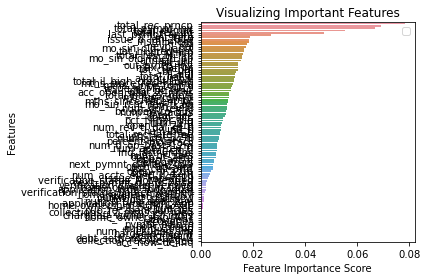

In [77]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
# Creating a bar plot
sns.barplot(x=feature_imp, y=list, orient = "h")
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.tight_layout()
plt.show()

### Easy Ensemble AdaBoost Classifier

In [78]:
# Train the EasyEnsembleClassifier
from imblearn.ensemble import EasyEnsembleClassifier
e_ada_boost = EasyEnsembleClassifier(random_state=42, n_estimators=100)
e_ada_boost = e_ada_boost.fit(X_train, y_train)

In [79]:
# Calculated the balanced accuracy score
from sklearn.metrics import balanced_accuracy_score
y_pred_ada = e_ada_boost.predict(X_test)
balanced_accuracy_score(y_test, y_pred_ada)

0.9173336169533888

In [80]:
# Display the confusion matrix
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred_ada)
print(confusion_matrix)

[[   78    10]
 [  707 12969]]


In [81]:
# Print the imbalanced classification report
from imblearn.metrics import classification_report_imbalanced
print(classification_report_imbalanced(y_test, y_pred_ada))

                   pre       rec       spe        f1       geo       iba       sup

  high_risk       0.10      0.89      0.95      0.18      0.92      0.84        88
   low_risk       1.00      0.95      0.89      0.97      0.92      0.85     13676

avg / total       0.99      0.95      0.89      0.97      0.92      0.85     13764

